In [18]:
from scipy.optimize import minimize
import scipy.stats
import torch
import torch.optim as optim
import scipy
import numpy as np
import matplotlib.pyplot as plt
from math import exp

# tree

In [2]:
class Node:
    def __init__(self, index, depth=0):
        self.index = index
        self.depth = depth
        self.left_child = None
        self.right_child = None
        self.left_bound = None
        self.right_bound = None

In [3]:
def breadth_first(root):
 
    current_nodes = [root]
    
    while True:
        
        prev_nodes = current_nodes
        current_nodes = []
        
        for node in prev_nodes:
            print(node.index)
            current_nodes.append(node.left_child)
            current_nodes.append(node.right_child)
        
        if all(node is None for node in current_nodes):
            break

In [4]:
# iterative tree building
def build_tree(root, depth):
    root.index = 0
    current_nodes = [root]
    
    counter = 1

    for i in range(0, depth):
        
        new_nodes = []
        
        for node in current_nodes:
            node.left_child = Node(counter, i+1)
            counter += 1
            node.right_child = Node(counter, i+1)
            counter += 1
            new_nodes.append(node.left_child)
            new_nodes.append(node.right_child)
        
        current_nodes = new_nodes.copy()
        
    return(root)

In [5]:
depth = 3
root = Node(0, 0)
build_tree(root, 3)

In [6]:
root.right_child.right_child.right_child.depth

3

In [7]:
cutpoints = [500, 250, 150, 275, 750, 600, 900]

def depth_first(root, max_depth=10):
 
    if (root == None):
        return
 
    st = []
 
    # start from root node (set current node to root node)
    curr = root
    curr_depth = 0
    # run till stack is not empty or current is
    # not NULL
    while (len(st) or curr != None):
     

        # Print left children while exist
        # and keep appending right into the
        # stack.
        while (curr != None):

            print(curr.index, end = " ")
            cutpoints[curr.index] = cutpoints[curr.index] + 2
            print(f"index:\t{curr.index}\tLB:\t{curr.left_bound}\tRB:\t{curr.right_bound}")
    
            if (curr.right_child != None):
            
                curr.right_child.left_bound = cutpoints[curr.index]
                curr.right_child.right_bound = curr.right_bound
                
                if(curr_depth < max_depth):
                    st.append(curr.right_child)

 
            if (curr.left_child != None):
                curr.left_child.left_bound = curr.left_bound
                curr.left_child.right_bound = cutpoints[curr.index]

            if (curr_depth < max_depth):
                curr = curr.left_child
                curr_depth += 1
            else:
                curr = None

         
        # We reach when curr is NULL, so We
        # take out a right child from stack
        if (len(st) > 0):

            curr = st[-1]
            st.pop()

In [8]:
# Iterative function for inorder tree traversal
def inorder(root, max_depth):
     
    # Set current to root of binary tree
    current = root
    current_depth = 0
    stack = [] # initialize stack
    out = []
     
    while True:
         
        # Reach the left most Node of the current Node
        if current is not None:
             
            # Place pointer to a tree node on the stack
            # before traversing the node's left subtree
            stack.append(current)
            current = current.left_child
            current_depth += 1


        # BackTrack from the empty subtree and visit the Node
        # at the top of the stack; however, if the stack is
        # empty you are done
        elif(stack):
            current = stack.pop()
            
            if current.depth <= max_depth:
                out.append(current)
         
            # We have visited the node and its left
            # subtree. Now, it's right subtree's turn
            current = current.right_child
 
        else:
            break

      
    return(out)

In [9]:
depth = 3
root = Node(0)
build_tree(root, depth)
# breadth_first(root)
# depth_first(root, 2)
for i in range(0, depth+1):
    out = inorder(root, i)
    print([c.index for c in out])

[0]
[1, 0, 2]
[3, 1, 4, 0, 5, 2, 6]
[7, 3, 8, 1, 9, 4, 10, 0, 11, 5, 12, 2, 13, 6, 14]


# data gen

In [10]:

# shifted and scaled sigmoid function
def test_sigmoid(x, a=0, b=1.):
    return 1 / (1 + (np.exp(-1 * (x - a) / b)))

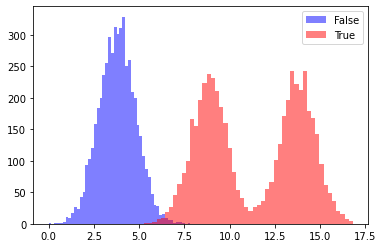

In [11]:
# from cutpoint_model import Model


N = 10000
P = 5

rs = np.random.RandomState(1978)

X = rs.randn(N, P)
w = rs.randn(P)

y_prob = test_sigmoid(X @ w)
y = (rs.rand(N) < y_prob).astype(int)
t = (rs.randn(N) + 5 * y + (rs.rand(N)> 0.5) * 5 * y )

# make times positive
t += abs(min(t))

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [12]:
# torch.autograd.set_detect_anomaly(True)
class Model:
    def __init__(self, X, t, sigmoid_temp = 0.01, depth = 1, cutpoint0=None, iterations = 1000):
        self.X = torch.tensor(X, dtype=torch.float)
        self.t = torch.tensor(t, dtype=torch.float)
        self.t_convert = (self.t - min(self.t)) / (max(self.t) - min(self.t))
        self.sigmoid_temp = sigmoid_temp 
        self.depth = depth
        self.iterations = iterations
        
        self.n_cutpoints = 2**(depth+1)-1
        self.theta = []
        for curr_depth in range(0, self.depth+1):
            self.theta.append(
                [torch.zeros( X.shape[1]+1, requires_grad=True).float()]
                * (sum([2**(i) for i in range(0, curr_depth+1)])+1))
#             self.theta.append([torch.zeros( X.shape[1]+1, requires_grad=True).float() for i in range(0,2^(curr_depth)+1)])

#         self.theta = [torch.zeros( X.shape[1]+1, requires_grad=True).float() for i in range(0,self.n_cutpoints)]
        
        self.cutpoint_logit = [torch.tensor(self.logit(torch.tensor(cutpoint)).item(), requires_grad=True) for cutpoint in cutpoint0]
    
        # set up cutpoint tree
        self.root = Node(0)
        root.left_bound = min(self.t)
        root.right_bound = max(self.t)
        self.root = build_tree(root, depth)
        
        
    def logit(self, x):
        return torch.log(x/ (1 - x))
    
    # shifted and scaled sigmoid function
    def sigmoid(self, x, a=0, b=1.):
        return 1 / (1 + (torch.exp(-1 * (x - a) / b)))
    
    
    def pred_value(self, x, theta):
        prod = torch.matmul(x,theta)
        return self.sigmoid(prod)
    
    
    def multinomial_loss(self, thetas, cutpoint_logits):

        
        t_scaled = (self.t - min(self.t)) / (max(self.t) - min(self.t))
        x1 = torch.cat([self.X, torch.ones((len(self.X), 1))], axis=1)

        cutpoints = [self.sigmoid(cp_logit) for cp_logit in cutpoint_logits]
        likelihood = 0
        prior = 0
        
        for lb, rb, theta in zip([0] + cutpoints, cutpoints + [1], thetas):
            left_boundary  = self.sigmoid(t_scaled, lb, self.sigmoid_temp)
            right_boundary = self.sigmoid(t_scaled, rb, self.sigmoid_temp)
        
            p_hat = self.pred_value(x1, theta)
            likelihood += -1 * torch.mean(torch.log(p_hat) * left_boundary * right_boundary)
    
        
        # prior loop
        for lb, curr, rb in zip([0] + cutpoints[:-1], cutpoints, cutpoints[1:] + [1]):
#             print(f"lb:\t{lb}\tcurr:\t{curr}\trb:\t{rb}")
            
            temp = (curr - lb) / (rb - lb)
            prior += -1 * torch.distributions.Beta(torch.tensor(1.5), torch.tensor(1.5)).log_prob(temp)
            
#         print('Likelihood = %.7e | Prior = %.7e' % (likelihood, prior))

        return likelihood + prior
    
    
    def train(self):
        flat_theta = [item for sublist in self.theta for item in sublist]

        optimizer = optim.Adam(flat_theta + self.cutpoint_logit, lr=0.001)
        loss = 0
        loss_layers = [0 for i in range(0, self.depth+1)]
        iteration_num = 1

        ######################################
        # training iteration

        while iteration_num < self.iterations:

#             if iteration_num % 10 == 0:
#                 print(iteration_num)
                
            #####################################
            # inorder traversal
            for current_depth in range(0, self.depth+1):

                nodes = inorder(self.root, current_depth)
                indices = [node.index for node in nodes]
                current_thetas = self.theta[current_depth]
                current_cutpoints_logit = [self.cutpoint_logit[i] for i in indices]
                loss_layers[current_depth] = self.multinomial_loss(current_thetas, current_cutpoints_logit)
            
            # end inorder traversal
            ###################################
            loss = sum(loss_layers)
            loss.backward(retain_graph=True)
            optimizer.step()

            # one optimization step
            iteration_num += 1
            
        # end training iteration
        ######################################




In [13]:
depth = 1
root = Node(0)
build_tree(root, depth)
inorder_traversal = inorder(root, depth)
print([c.index for c in inorder_traversal])
equal_spacings = [(i+1)/(2**(depth+1)) for i in range(0, 2**(depth+1) + -1)]
cutpoint0 = [0] * len(inorder_traversal)

for i in range(0, len(inorder_traversal)):
    index = inorder_traversal[i].index
    cutpoint0[index] = equal_spacings[i]

print(cutpoint0)

[1, 0, 2]
[0.5, 0.25, 0.75]


In [14]:
m = Model(X, t, depth = depth, cutpoint0=cutpoint0)


In [15]:
m.train()

C:\Users\jimmy\anaconda3\lib\site-packages\torch\optim\adam.py:74: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


[tensor(11.4505, grad_fn=<AddBackward0>), tensor(7.7723, grad_fn=<AddBackward0>), tensor(14.3368, grad_fn=<AddBackward0>)]
[8.402695286809909, 4.201347643404954, 12.604042930214863]


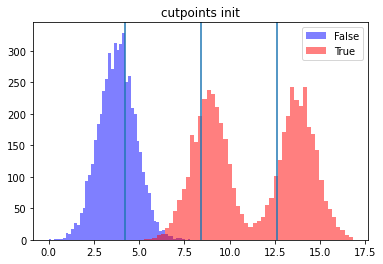

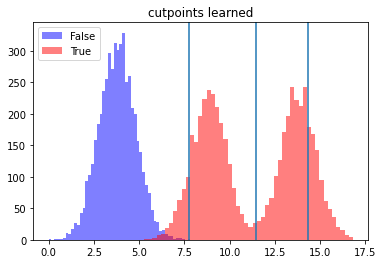

In [16]:
cutpoints = [ m.sigmoid(cutpoint) * (max(t) - min(t)) + min(t) for cutpoint in m.cutpoint_logit ]
print(cutpoints)
cutpoints_init = [cutpoint * (max(t)-min(t)) + min(t) for cutpoint in cutpoint0]
print(cutpoints_init)

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")

for cutpoint in cutpoints_init:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints init")
plt.show()

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")

for cutpoint in cutpoints:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints learned")
plt.show()

# sksurv

### Breast Cancer data

In [17]:
from sksurv.datasets import load_breast_cancer

data_x, data_y = load_breast_cancer()
y_df = pd.DataFrame.from_records(data_y)

# cut last covariates that are strings
X = torch.tensor(data_x.iloc[:, 1:-3].values)

t = torch.from_numpy(y_df["t.tdm"].values)


plt.hist(y_df[~y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="blue", label="no metastases")
plt.hist(y_df[y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="red", label="metastases")
plt.legend()

plt.show()

NameError: name 'pd' is not defined

In [17]:
depth = 1
root = Node(0)
build_tree(root, depth)
inorder_traversal = inorder(root, depth)
# print([c.index for c in inorder_traversal])
equal_spacings = [(i+1)/(2**(depth+1)) for i in range(0, 2**(depth+1) + -1)]
cutpoint0 = [0] * len(inorder_traversal)

for i in range(0, len(inorder_traversal)):
    index = inorder_traversal[i].index
    cutpoint0[index] = equal_spacings[i]

print(cutpoint0)
m = Model(X, t, depth = depth, cutpoint0=cutpoint0)


[0.5, 0.25, 0.75]


<ipython-input-11-117ce9190dc8>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
<ipython-input-11-117ce9190dc8>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t = torch.tensor(t, dtype=torch.float)


In [18]:
m.train()

C:\Users\jimmy\anaconda3\lib\site-packages\torch\optim\adam.py:74: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


[tensor(4290.4685, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(2485.5287, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(7133.8343, dtype=torch.float64, grad_fn=<AddBackward0>)]
[tensor(4616.5000, dtype=torch.float64), tensor(2370.7500, dtype=torch.float64), tensor(6862.2500, dtype=torch.float64)]


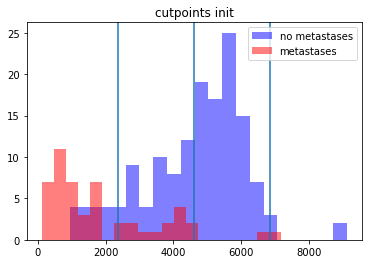

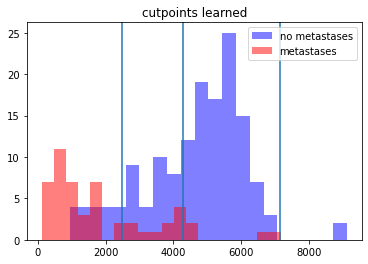

In [19]:
cutpoints = [ m.sigmoid(cutpoint) * (max(t) - min(t)) + min(t) for cutpoint in m.cutpoint_logit ]
print(cutpoints)
cutpoints_init = [cutpoint * (max(t)-min(t)) + min(t) for cutpoint in cutpoint0]
print(cutpoints_init)

plt.hist(y_df[~y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="blue", label="no metastases")
plt.hist(y_df[y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="red", label="metastases")
plt.legend()
for cutpoint in cutpoints_init:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints init")
plt.show()

plt.hist(y_df[~y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="blue", label="no metastases")
plt.hist(y_df[y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="red", label="metastases")
plt.legend()
for cutpoint in cutpoints:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints learned")
plt.show()

### Worcester Heart Attack Study

The dataset has 500 samples and 14 features. The endpoint is death, which occurred for 215 patients (43.0%).

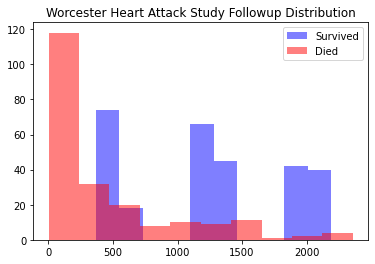

In [20]:
from sksurv.datasets import load_whas500

data_x, data_y = load_whas500()
y_df = pd.DataFrame.from_records(data_y)


X = torch.tensor(data_x[["age", "bmi", "diasbp", "hr", "los", "sysbp"]].values)

t = torch.from_numpy(y_df["lenfol"].values)
plt.title("Worcester Heart Attack Study Followup Distribution")
plt.hist(t[~y_df["fstat"].values], color="blue", alpha = 0.5, label="Survived")
plt.hist(t[y_df["fstat"].values], color="red", alpha = 0.5, label = "Died")
plt.legend()
plt.show()

In [25]:
depth = 1
root = Node(0)
build_tree(root, depth)
inorder_traversal = inorder(root, depth)
print([c.index for c in inorder_traversal])
equal_spacings = [(i+1)/(2**(depth+1)) for i in range(0, 2**(depth+1) + -1)]
cutpoint0 = [0] * len(inorder_traversal)

for i in range(0, len(inorder_traversal)):
    index = inorder_traversal[i].index
    cutpoint0[index] = equal_spacings[i]

# print(cutpoint0)
m = Model(X, t, depth = depth, cutpoint0=cutpoint0)


[1, 0, 2]


<ipython-input-11-117ce9190dc8>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
<ipython-input-11-117ce9190dc8>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t = torch.tensor(t, dtype=torch.float)


In [26]:
m.train()

[tensor(1176.3459, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(565.9273, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1740.0970, dtype=torch.float64, grad_fn=<AddBackward0>)]
[tensor(1179.5000, dtype=torch.float64), tensor(590.2500, dtype=torch.float64), tensor(1768.7500, dtype=torch.float64)]


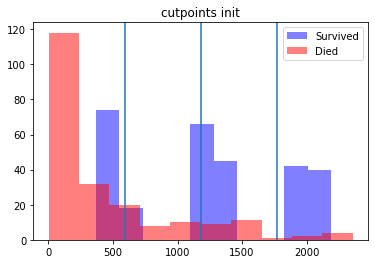

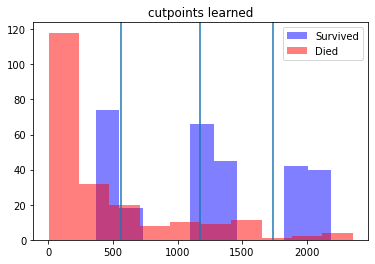

In [27]:
cutpoints = [ m.sigmoid(cutpoint) * (max(t) - min(t)) + min(t) for cutpoint in m.cutpoint_logit ]
print(cutpoints)
cutpoints_init = [cutpoint * (max(t)-min(t)) + min(t) for cutpoint in cutpoint0]
print(cutpoints_init)


plt.title("Worcester Heart Attack Study Followup Distribution")
plt.hist(t[~y_df["fstat"].values], color="blue", alpha = 0.5, label="Survived")
plt.hist(t[y_df["fstat"].values], color="red", alpha = 0.5, label = "Died")
plt.legend()
plt.title("cutpoints init")

for cutpoint in cutpoints_init:
    plt.axvline(cutpoint)
plt.show()

plt.title("Worcester Heart Attack Study Followup Distribution")
plt.hist(t[~y_df["fstat"].values], color="blue", alpha = 0.5, label="Survived")
plt.hist(t[y_df["fstat"].values], color="red", alpha = 0.5, label = "Died")
plt.legend()
plt.title("cutpoints learned")

for cutpoint in cutpoints:
    plt.axvline(cutpoint)
plt.show()

In [28]:
cutpoint0 = [0.2, 0.1, 0.3]
m = Model(X, t, depth = depth, cutpoint0=cutpoint0)
m.train()

<ipython-input-11-117ce9190dc8>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
<ipython-input-11-117ce9190dc8>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t = torch.tensor(t, dtype=torch.float)


[tensor(1016.7258, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(523.6002, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1525.5458, dtype=torch.float64, grad_fn=<AddBackward0>)]
[tensor(472.4000, dtype=torch.float64), tensor(236.7000, dtype=torch.float64), tensor(708.1000, dtype=torch.float64)]


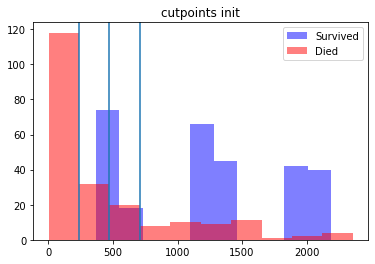

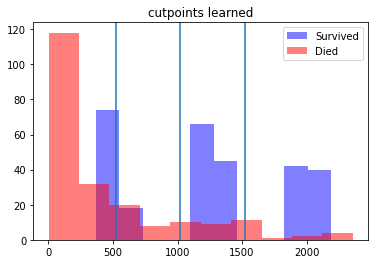

In [29]:
cutpoints = [ m.sigmoid(cutpoint) * (max(t) - min(t)) + min(t) for cutpoint in m.cutpoint_logit ]
print(cutpoints)
cutpoints_init = [cutpoint * (max(t)-min(t)) + min(t) for cutpoint in cutpoint0]
print(cutpoints_init)

plt.title("Worcester Heart Attack Study Followup Distribution")
plt.hist(t[~y_df["fstat"].values], color="blue", alpha = 0.5, label="Survived")
plt.hist(t[y_df["fstat"].values], color="red", alpha = 0.5, label = "Died")
plt.legend()
plt.title("cutpoints init")

for cutpoint in cutpoints_init:
    plt.axvline(cutpoint)
plt.show()

plt.title("Worcester Heart Attack Study Followup Distribution")
plt.hist(t[~y_df["fstat"].values], color="blue", alpha = 0.5, label="Survived")
plt.hist(t[y_df["fstat"].values], color="red", alpha = 0.5, label = "Died")
plt.legend()
plt.title("cutpoints learned")

for cutpoint in cutpoints:
    plt.axvline(cutpoint)
plt.show()

# more modes?!

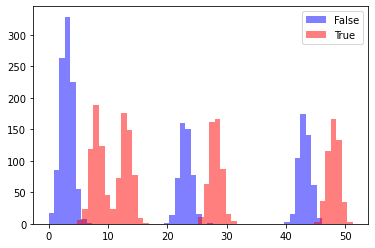

In [30]:

N = 1000
P = 5

rs = np.random.RandomState(1978)
# python please I want a do while loop

X = rs.randn(N, P)
w = rs.randn(P)

y_prob = test_sigmoid(X @ w)
y = (rs.rand(N) < y_prob).astype(int)
t = (rs.randn(N) + 5 * i * y )


for i in range(0, 3):
    X_i = rs.randn(N, P)
    w_i = rs.randn(P)

    y_prob = test_sigmoid(X_i @ w_i)
    y_i = (rs.rand(N) < y_prob).astype(int)
    t_i = (rs.randn(N) + 20 * i + 5 * y_i )
    X = np.concatenate((X, X_i))
    t = np.concatenate((t, t_i))
    y = np.concatenate((y, y_i))
    

# make times positive
t += abs(min(t))

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [31]:
depth = 2
root = Node(0)
build_tree(root, depth)
inorder_traversal = inorder(root, depth)
print([c.index for c in inorder_traversal])
equal_spacings = [(i+1)/(2**(depth+1)) for i in range(0, 2**(depth+1) + -1)]
cutpoint0 = [0] * len(inorder_traversal)

for i in range(0, len(inorder_traversal)):
    index = inorder_traversal[i].index
    cutpoint0[index] = equal_spacings[i]/2

print(cutpoint0)

[3, 1, 4, 0, 5, 2, 6]
[0.25, 0.125, 0.375, 0.0625, 0.1875, 0.3125, 0.4375]


In [32]:
m = Model(X, t, depth = depth, cutpoint0=cutpoint0)
m.train()

[tensor(17.6848, grad_fn=<AddBackward0>), tensor(6.4815, grad_fn=<AddBackward0>), tensor(33.4426, grad_fn=<AddBackward0>), tensor(3.0780, grad_fn=<AddBackward0>), tensor(10.8425, grad_fn=<AddBackward0>), tensor(23.7762, grad_fn=<AddBackward0>), tensor(39.2656, grad_fn=<AddBackward0>)]
[12.819149816759504, 6.409574908379752, 19.228724725139255, 3.204787454189876, 9.614362362569628, 16.02393727094938, 22.43351217932913]


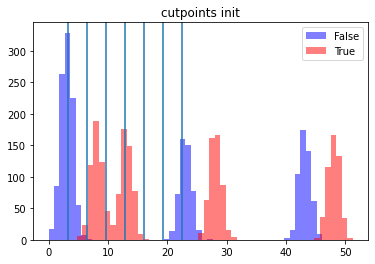

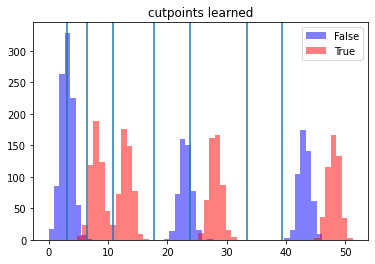

In [33]:
cutpoints = [ m.sigmoid(cutpoint) * (max(t) - min(t)) + min(t) for cutpoint in m.cutpoint_logit ]
print(cutpoints)
cutpoints_init = [cutpoint * (max(t)-min(t)) + min(t) for cutpoint in cutpoint0]
print(cutpoints_init)

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")

for cutpoint in cutpoints_init:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints init")
plt.show()

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")

for cutpoint in cutpoints:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints learned")
plt.show()



# NACD Data

In [62]:
df= pd.read_csv('http://pssp.srv.ualberta.ca/system/predictors/datasets/000/000/032/original/All_Data_updated_may2011_CLEANED.csv?1350302245')

In [63]:
t = df["SURVIVAL"]
# make times positive
t += abs(min(t))

# censored: 1 is that they were censored 0 they experienced the event
y = 1 - df["CENSORED"]

numrc_cols = df.nunique() > 2
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['SURVIVAL', 'CENSORED']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

print('There are', X.shape[1], 'features')
print(f"There are {X.shape[0]} patients")

There are 51 features
There are 2402 patients


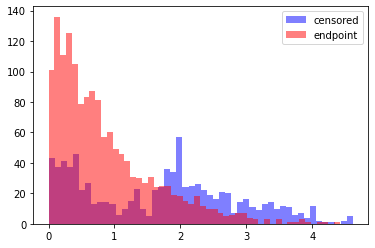

In [30]:
plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="endpoint")
plt.legend()
plt.show()

In [31]:
depth = 2
root = Node(0)
build_tree(root, depth)
inorder_traversal = inorder(root, depth)
print([c.index for c in inorder_traversal])
equal_spacings = [(i+1)/(2**(depth+1)) for i in range(0, 2**(depth+1) + -1)]
cutpoint0 = [0] * len(inorder_traversal)

for i in range(0, len(inorder_traversal)):
    index = inorder_traversal[i].index
    cutpoint0[index] = equal_spacings[i]/2

print(cutpoint0)

[3, 1, 4, 0, 5, 2, 6]
[0.25, 0.125, 0.375, 0.0625, 0.1875, 0.3125, 0.4375]


In [32]:
m = Model(X, t, depth = depth, cutpoint0=cutpoint0)
m.train()

C:\Users\jimmy\anaconda3\lib\site-packages\torch\optim\adam.py:74: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


[1.22806715965271, 0.511125385761261, 2.6099259853363037, 0.2305835485458374, 0.7583838701248169, 1.9961788654327393, 3.505774736404419]
[1.154091387259079, 0.5770456936295395, 1.7311370808886184, 0.28852284681476975, 0.8655685404443092, 1.4426142340738488, 2.019659927703388]


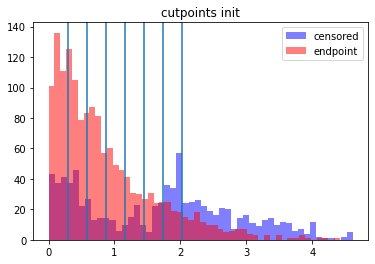

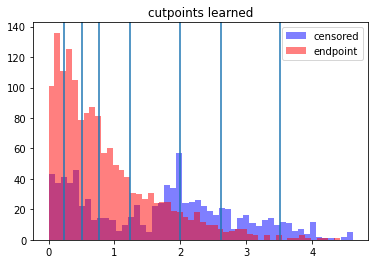

In [50]:
cutpoints = [ (m.sigmoid(cutpoint) * (max(t) - min(t)) + min(t)).item() for cutpoint in m.cutpoint_logit ]
print(cutpoints)
cutpoints_init = [cutpoint * (max(t)-min(t)) + min(t) for cutpoint in cutpoint0]
print(cutpoints_init)

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="endpoint")

for cutpoint in cutpoints_init:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints init")
plt.show()

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="endpoint")

for cutpoint in cutpoints:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints learned")
plt.show()

# Support dataset

In [65]:
FILL_VALUES = {
    'alb': 3.5,
    'pafi': 333.3,
    'bili': 1.01,
    'crea': 1.01,
    'bun': 6.51,
    'wblc': 9.,
    'urine': 2502.
}

TO_DROP = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
TO_DROP = TO_DROP + ['sfdm2', 'hospdead']

# load, drop columns, fill using specified fill values
df = pd.read_csv('datasets/support2.csv').drop(TO_DROP,axis=1).fillna(value=FILL_VALUES)

# get dummies for categorical vars
df = pd.get_dummies(df, dummy_na=True)

# fill remaining values to the median

df = df.fillna(df.median())

# standardize numeric columns

numrc_cols = df.dtypes == 'float64'
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['death', 'd.time']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

t = df["d.time"]
y = df['death']

print('There are', X.shape[1], 'features')
print(f'There are {X.shape[0]} patients')

There are 61 features
There are 9105 patients


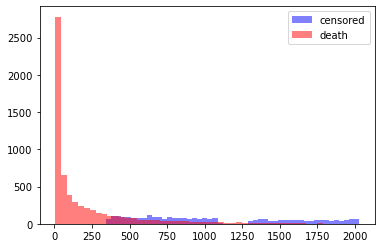

In [66]:
plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="death")
plt.legend()
plt.show()

In [67]:
depth = 2
root = Node(0)
build_tree(root, depth)
inorder_traversal = inorder(root, depth)
print([c.index for c in inorder_traversal])
equal_spacings = [(i+1)/(2**(depth+1)) for i in range(0, 2**(depth+1) + -1)]
cutpoint0 = [0] * len(inorder_traversal)

for i in range(0, len(inorder_traversal)):
    index = inorder_traversal[i].index
    cutpoint0[index] = equal_spacings[i]/2

print(cutpoint0)

[3, 1, 4, 0, 5, 2, 6]
[0.25, 0.125, 0.375, 0.0625, 0.1875, 0.3125, 0.4375]


In [70]:
m = Model(X, t.values, depth = depth, cutpoint0=cutpoint0)
m.train()

[674.1109008789062, 279.9170227050781, 1204.4197998046875, 113.35018920898438, 412.2880554199219, 984.2603759765625, 1540.7137451171875]
[509.5, 256.25, 762.75, 129.625, 382.875, 636.125, 889.375]


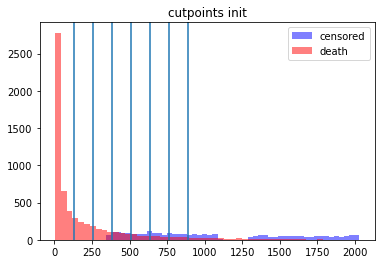

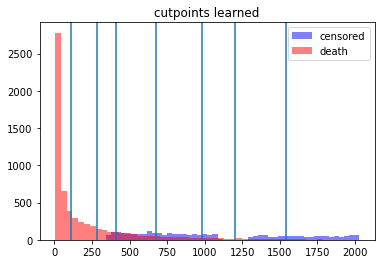

In [71]:
cutpoints = [ (m.sigmoid(cutpoint) * (max(t) - min(t)) + min(t)).item() for cutpoint in m.cutpoint_logit ]
print(cutpoints)
cutpoints_init = [cutpoint * (max(t)-min(t)) + min(t) for cutpoint in cutpoint0]
print(cutpoints_init)

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="death")

for cutpoint in cutpoints_init:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints init")
plt.show()

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="death")

for cutpoint in cutpoints:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints learned")
plt.show()